In [ ]:
#this project developed by Mostafa Karimi mostafakarimi318@gmail.com
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


df = pd.read_csv('/content/drive/MyDrive/Project/Iran Khodro-a.csv')
df.rename(columns={'Close':'Trade Close', 'Volume':'Trade Volume'}, inplace=True) #Rename some column 
print('Number of rows and columns:', df.shape)
length = df.shape[0] #number of rows
#print(len)

df.head() #Show us head and 5 first rows of file


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seq_length = 20
step_predict = 4

#create new coloumn (close_log)= log( (trade close) / (pervious day of trade close) )
df['close_log'] = np.log(df['Trade Close'] / df['Trade Close'].shift(1)) 

#create new coloumn (vol_log) = log( (trade volume) / (pervious day of trade volume) )
df['vol_log'] = np.log(df['Trade Volume'] / df['Trade Volume'].shift(1))

#create new coloumn (target_log) = log( (t+4th trade close) / (trade close))
df['target_log'] = np.log(df['Trade Close'].shift(-step_predict) / df['Trade Close'])

#pandas.core.frame.DataFrame
train_df = df[:int(len(df['Trade Close'])*0.4)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(len(df['Trade Close'])*0.4):int(len(df['Trade Close'])*0.6)].copy()      
val_df.reset_index(inplace=True)
test_df = df.loc[int(len(df['Trade Close'])*0.6):int(len(df['Trade Close'])*0.8)].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape






#numpy.ndarray
X_train = []
y_train = []    #20          1702        -        4 => i in range (20,1698)
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
#X_train.shape[0] arrays  that contains X_train.shape[0] arrays each with 2 elements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2)) 
#X_train.shape, y_train.shape

X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))


X_val.shape, y_val.shape


In [ ]:
# initialize network (1 layer)
                          #X_train.shape[1] =19
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=False, recurrent_regularizer='l2')(inputs)

dropout1 = Dropout(rate=0.8)(lstm1)

# fully connected layers

fc1 = Dense(units=50)(dropout1)
dropoutfc1 = Dropout(rate=0.8)(fc1)
fc2 = Dense(units=25)(dropoutfc1)
dropoutfc2 = Dropout(rate=0.8)(fc2)
fc3 = Dense(units=10)(dropoutfc2)
dropoutfc3 = Dropout(rate=0.8)(fc3)
output = Dense(units=1)(dropoutfc3)

# fit lstm model

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(optimizer = 'Adam', loss = 'mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 128, validation_data=(X_val, y_val))


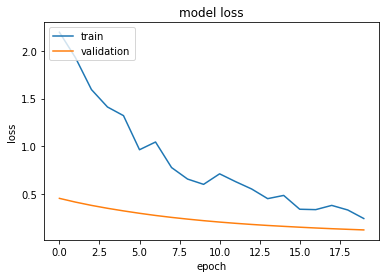

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:

train_price = train_df[seq_length+step_predict:train_df.shape[0]]['Trade Close']
train_predicted = lstm_model.predict(X_train)
inv = train_df[seq_length:train_df.shape[0]-step_predict]['Trade Close'].values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

(1262, 1262)

In [ ]:

# visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]]['Date'].values
plt.figure(figsize=(20,10))
plt.plot(date, train_price, color = 'red', label = 'IranKhodro 2001-2021')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted IranKhodro 2001-2021')
plt.xticks(np.arange(0,len(train_predicted),100))
plt.title('TRAIN SET: IranKhodro Stock Price 2001 Till 2021')
plt.xlabel('Date')
plt.ylabel('IranKhodro 2001-2021 Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {round(mean_squared_error(train_price, train_predicted, squared=False),4)}')
print(f'MAE: {round(mean_absolute_error(train_price, train_predicted),4)}')
print(f'r2_score: {round(r2_score(train_price, train_predicted),4)}')

In [38]:
"""### Validation set"""

val_price = val_df[seq_length+step_predict:val_df.shape[0]]['Trade Close']
val_predicted = lstm_model.predict(X_val)
inv = val_df[seq_length:val_df.shape[0]-step_predict]['Trade Close'].values.reshape(-1, 1)
val_predicted = inv * np.exp(1)**val_predicted


len(val_price), len(val_predicted)


(619, 619)

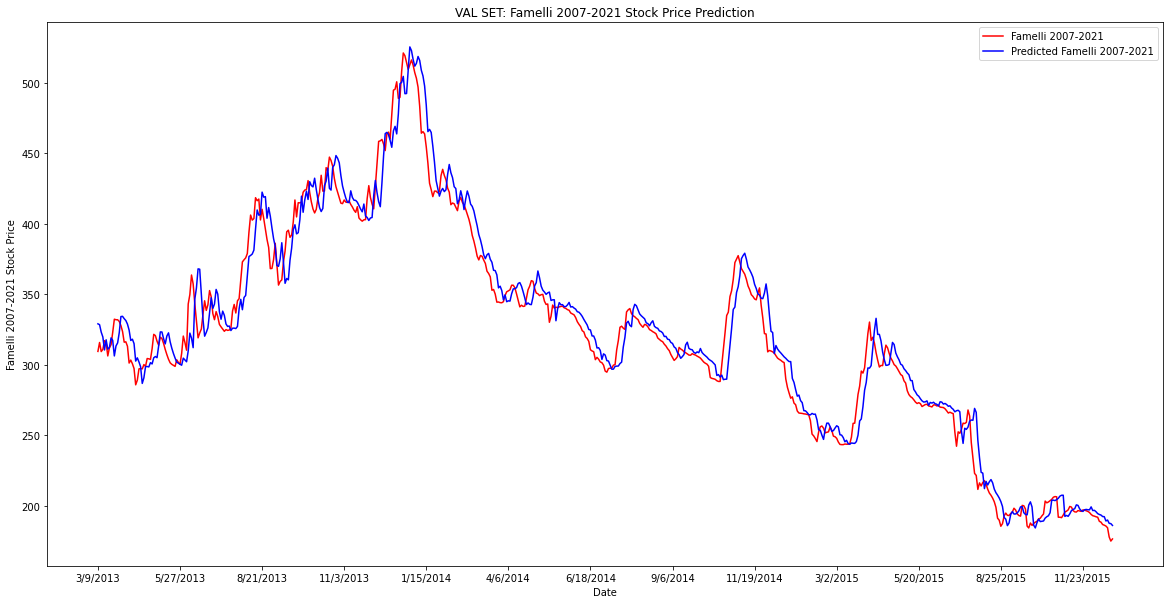

RMSE: 14.5477
MAE: 11.0681
r2_score: 0.9631


In [39]:

# visualising the results
date = val_df[seq_length+step_predict:val_df.shape[0]]['Date'].values
plt.figure(figsize=(20,10))
plt.plot(date, val_price, color = 'red', label = 'IranKhodro 2001-2021')
plt.plot(date, val_predicted, color = 'blue', label = 'Predicted IranKhdoro 2001-2021')
plt.xticks(np.arange(0,len(val_predicted),50))
plt.title('VAL SET: IranKhodro 2001-2021 Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('IranKhodro 2001-2021 Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {round(mean_squared_error(val_price, val_predicted, squared=False),4)}')
print(f'MAE: {round(mean_absolute_error(val_price, val_predicted),4)}')
print(f'r2_score: {round(r2_score(val_price, val_predicted),4)}')

In [40]:

X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
#X_test.shape, y_test.shape

test_price = test_df[seq_length+step_predict:test_df.shape[0]]['Trade Close']
test_predicted = lstm_model.predict(X_test)
inv = test_df[seq_length:test_df.shape[0]-step_predict]['Trade Close'].values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
#len(test_price), len(test_predicted)


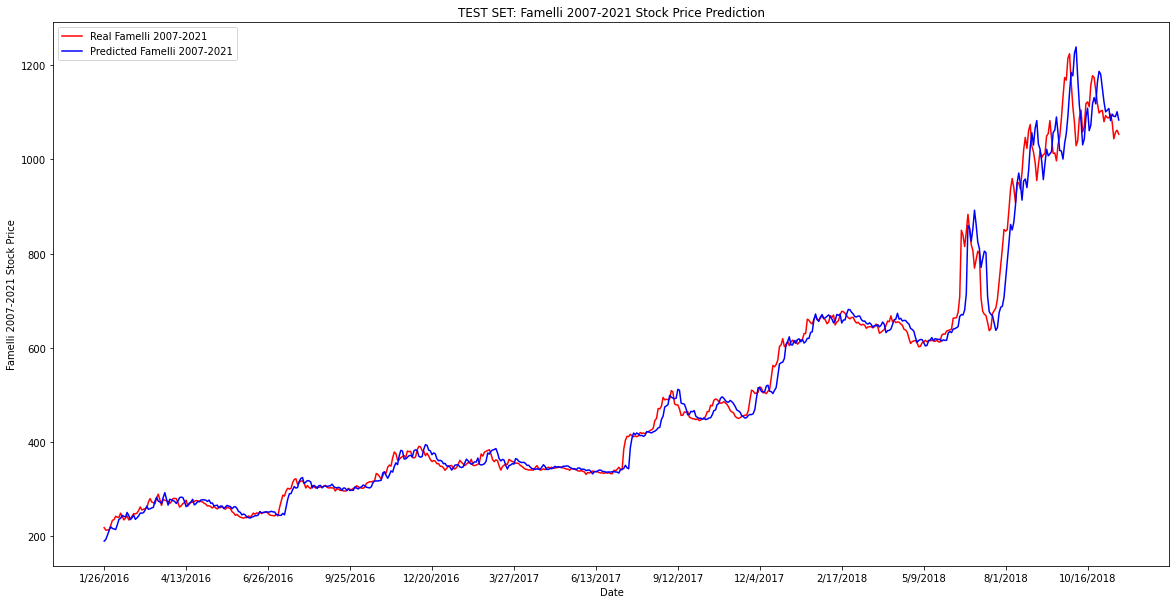

RMSE: 33.2825
MAE: 18.6244
r2_score: 0.982


In [41]:

# visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]]['Date'].values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real IranKhodro 2001-2021')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted IranKhodro 2001-2021')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET: IranKhodro 2001-2021 Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('IranKhodro 2001-2021 Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {round(mean_squared_error(test_price, test_predicted, squared=False),4)}')
#notice That MAE not RMAE
print(f'MAE: {round(mean_absolute_error(test_price, test_predicted),4)}')
print(f'r2_score: {round(r2_score(test_price, test_predicted),4)}')
